# Predicting Superconductor Critical Temperature

This notebook builds and evaluates several regression models to predict `critical_temp` from the UCI Superconductivity dataset.  
It covers:

1. **Setup & Reproducibility**
2. **Data Loading**
3. **Exploratory Data Analysis (EDA)**
4. **Preprocessing & Feature Engineering**
5. **Modeling & Hyperparameter Tuning**
6. **Stacked Ensemble**
7. **Final Evaluation & Results Export**

All code is thoroughly commented, uses consistent naming, and follows best practices for reproducibility.


In [11]:
# 0. SETUP & REPRODUCIBILITY
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import zipfile
import io

# Fix all seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Display settings
pd.set_option('display.max_columns', None)

## 1. DATA LOADING

- Reads `train.csv` assumed in the working directory.
- Verifies shape and prints sample.


In [12]:
# Load dataset
def load_superconductivity_data(url):
    """
    Download the superconductivity data from the given URL (a zip file) and extract train.csv.
    """
    print(f"Downloading data from {url}...")
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Find train.csv file inside zip archive
            train_path = None
            for name in z.namelist():
                if name.endswith('train.csv'):
                    train_path = name
                    break
            if train_path is None:
                raise FileNotFoundError("train.csv not found in the zip file")
            print(f"Extracting {train_path}...")
            with z.open(train_path) as f:
                df = pd.read_csv(f)
        print("Data loaded successfully.")
        return df
    except Exception as e:
        print(f"Error: {e}")
        return None


# URL for data (zip file containing train.csv)
data_url = "https://archive.ics.uci.edu/static/public/464/superconductivty+data.zip"
df = load_superconductivity_data(data_url)
if df is None:
    exit("Exiting because the data could not be loaded.")

print(f"Dataset shape: {df.shape}")
df.head()

Extracting train.csv...
Data loaded successfully.
Dataset shape: (21263, 82)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,3572.596624,81.8375,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.666920,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,3632.649185,90.8900,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.603000,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,53.656268,775.425,1010.820000,718.152900,939.009036,1.305967,0.773620,810.6,743.164286,323.811808,354.804183,160.25,104.685714,136.126003,84.214573,1.259244,1.132547,205,49.314286,75.237540,67.797712,4654.35725,2999.159429,724.953211,53.974022,1.033129,0.760305,8958.571,1667.383429,3306.162897,3592.019281,81.8375,112.213571,60.123179,101.082152,1.159687,0.786007,127.05,81.207857,51.433712,41.639878,6.9055,3.822571,3.479475,1.037439,1.088575,0.927479,12.878,1.757143,4.599064,4.649635,107.756645,60.943760,7.062488,0.619095,0.308148,0.250477,399.97342,57.127669,168.854244,138.540613,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,53.639405,775.425,1

## 2. EXPLORATORY DATA ANALYSIS (EDA)

- Check for missing values
- Target distribution
- Correlation heatmap (top features)


Missing values per column:
 Series([], dtype: int64)


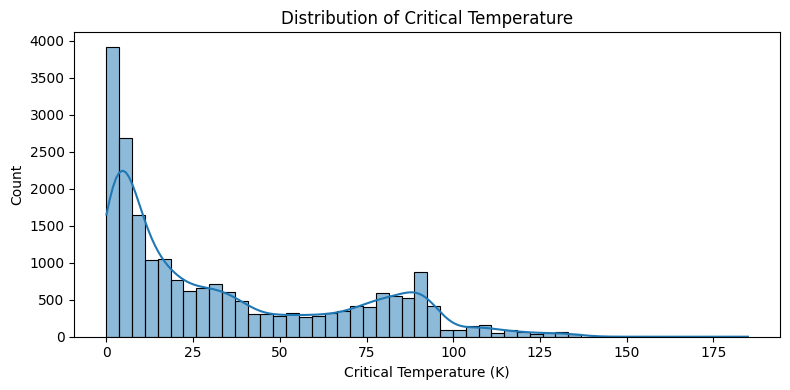

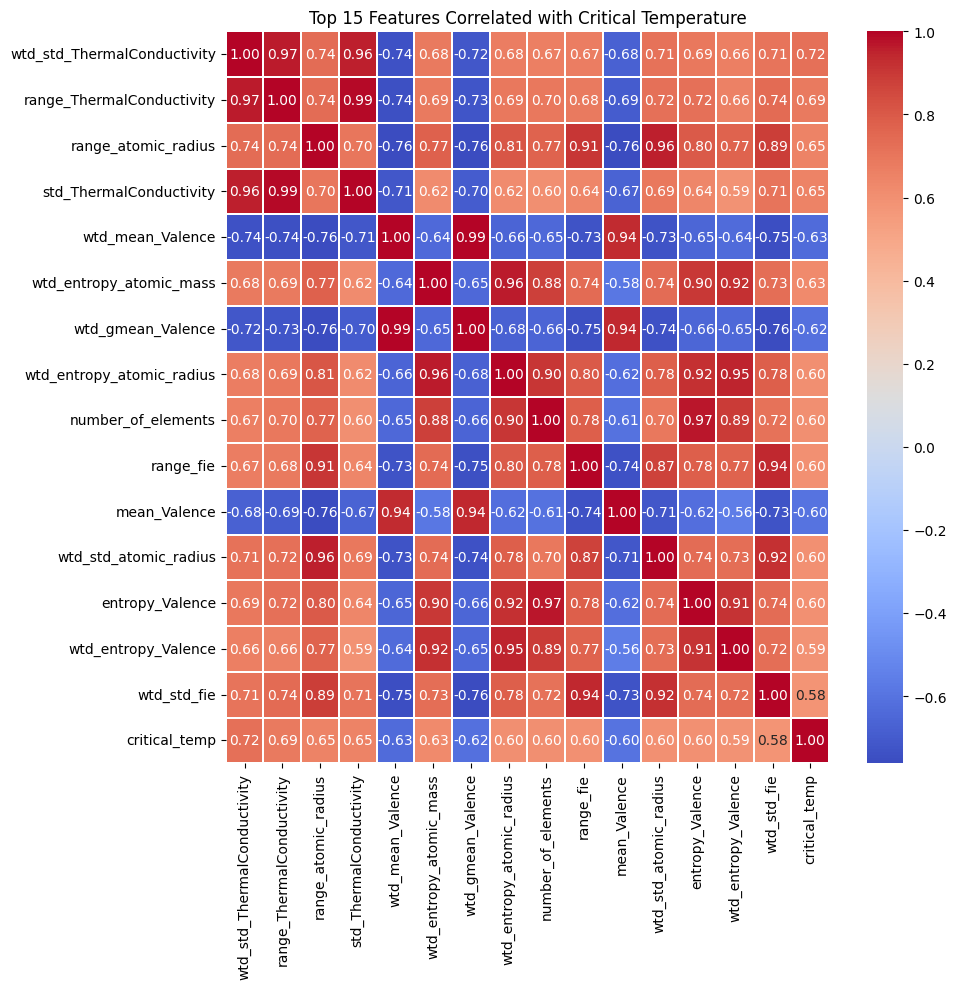

In [13]:
# 2.1 Missing values
import seaborn as sns
import matplotlib.pyplot as plt
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# 2.2 Target distribution

plt.figure(figsize=(8, 4))
sns.histplot(df['critical_temp'], bins=50, kde=True)
plt.title("Distribution of Critical Temperature")
plt.xlabel("Critical Temperature (K)")
plt.ylabel("Count")
plt.tight_layout()

# 2.3 Correlation heatmap of top 15 features with target
corr = df.corr()['critical_temp'].abs().sort_values(ascending=False).iloc[1:16]
plt.figure(figsize=(10, 10))
sns.heatmap(df[corr.index.tolist() + ['critical_temp']].corr(), annot=True,
            fmt=".2f", cmap='coolwarm', linecolor='white', linewidths=0.1,)
plt.title("Top 15 Features Correlated with Critical Temperature")
plt.tight_layout()

## 3. PREPROCESSING & FEATURE ENGINEERING

1. **Impute** (median)
2. **Scale** (Standard)
3. **Feature Selection** (SelectKBest)
4. **PCA** (retain 95% variance)
5. **Polynomial Features** (only for linear models)
6. All wrapped in a **ColumnTransformer → Pipeline** to avoid leakage.


Original features: 81, Reduced features: 17


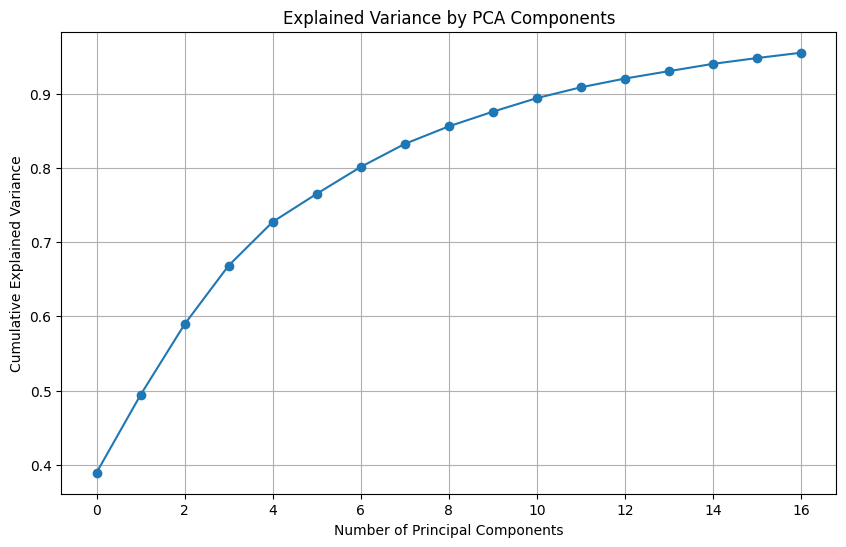

In [14]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Separate features and target
X = df.drop('critical_temp', axis=1)
y = df['critical_temp']

# Numeric feature names
numeric_features = X.columns.tolist()

# 3.1 Numeric transformer (impute + scale)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 3.2 Feature selection: keep top 50 by univariate F-test
feature_selector = SelectKBest(score_func=f_regression, k=50)

# 3.3 Dimensionality reduction: PCA (retain 95% variance)
pca_transformer = PCA(n_components=0.95, random_state=SEED)


def apply_pca(X, n_components=0.95):
    """
    Applies PCA to the data, retaining the specified variance.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    print(
        f"Original features: {X.shape[1]}, Reduced features: {X_pca.shape[1]}")
    # Explained variance plot
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by PCA Components')
    plt.grid(True)
    plt.show()

    return X_pca


X_pca = apply_pca(X)

# 3.4 Define full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num_impute_scale', numeric_transformer, numeric_features),
    ('select_kbest', feature_selector, numeric_features),
    ('pca', pca_transformer, numeric_features)
], remainder='drop', verbose_feature_names_out=False)

## 4. MODELING & HYPERPARAMETER TUNING

- Uses **5-fold CV** with **RandomizedSearchCV**
- Evaluates **RMSE**, **MAE**, **R²**
- Includes: **RandomForest**, **XGBoost**, **LightGBM**, **ElasticNet**
- Early stopping for boosted models


In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import lightgbm as lgb

# 4.1 Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

# Common CV settings
cv_folds = 5
scoring = 'neg_root_mean_squared_error'
n_iter_search = 50

# Container for best models and results
best_models = {}
tuning_results = []

# 4.2 Define model pipelines and hyperparameter grids
model_defs = {
    'RandomForest': {
        'estimator': RandomForestRegressor(random_state=SEED),
        'params': {
            'model__n_estimators': [100, 200, 500],
            'model__max_depth': [None, 10, 20, 30],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4]
        }
    },
    'XGBoost': {
        'estimator': xgb.XGBRegressor(random_state=SEED, objective='reg:squarederror', eval_metric='rmse'),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__max_depth': [3, 6, 9],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0]
        },
        'fit_kwargs': {
            'early_stopping_rounds': 10,
            'eval_set': [(X_test, y_test)],
            'verbose': False
        }
    },
    'LightGBM': {
        'estimator': lgb.LGBMRegressor(random_state=SEED),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__learning_rate': [0.01, 0.05, 0.1],
            'model__num_leaves': [31, 50, 70],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0]
        },
        'fit_kwargs': {
            'early_stopping_rounds': 10,
            'eval_set': [(X_test, y_test)],
            'verbose': -1
        }
    },
    'ElasticNet': {
        'estimator': ElasticNet(random_state=SEED, max_iter=5000),
        'params': {
            'model__alpha': [0.1, 1.0, 10.0],
            'model__l1_ratio': [0.2, 0.5, 0.8]
        }
    }
}

# 4.3 Run RandomizedSearchCV for each model
for name, cfg in model_defs.items():
    print(f"\n=== Tuning {name} ===")
    # Build full pipeline: preprocessing → model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', cfg['estimator'])
    ])
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=cfg['params'],
        n_iter=n_iter_search,
        scoring=scoring,
        cv=cv_folds,
        random_state=SEED,
        n_jobs=-1,
        refit=True
    )
    # Fit with early stopping if provided
    fit_kwargs = cfg.get('fit_kwargs', {})
    search.fit(X_train, y_train, **fit_kwargs)

    # Store best pipeline
    best_models[name] = search.best_estimator_
    print(f"Best params for {name}: {search.best_params_}")

    # Evaluate on test set
    y_pred = search.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    tuning_results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# Summary of tuning results
results_df = pd.DataFrame(tuning_results).set_index(
    'Model').sort_values('RMSE')
print("\n--- Tuning Results ---")
display(results_df)


=== Tuning RandomForest ===


## 5. STACKED ENSEMBLE

Builds a **StackingRegressor** over the top 3 tuned models with a Ridge meta-learner.


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Select top 3 base learners by RMSE
top_models = results_df.index[:3].tolist()
estimators = [(name, best_models[name]) for name in top_models]

stacker = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0, random_state=SEED),
    cv=cv_folds,
    n_jobs=-1,
    passthrough=True
)

# Train & evaluate
stacker.fit(X_train, y_train)
y_pred_stack = stacker.predict(X_test)

rmse_stack = mean_squared_error(y_test, y_pred_stack, squared=False)
mae_stack = mean_absolute_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"\nStacked Ensemble RMSE: {rmse_stack:.4f}")
print(f"Stacked Ensemble MAE : {mae_stack:.4f}")
print(f"Stacked Ensemble R2  : {r2_stack:.4f}")

## 6. FINAL EVALUATION & VISUALIZATION

- **Actual vs. Predicted**
- **Residual Plot**


In [ ]:
# 6.1 Actual vs Predicted
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_stack, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Critical Temperature")
plt.ylabel("Predicted Critical Temperature")
plt.title("Actual vs Predicted (Stacked Ensemble)")
plt.tight_layout()

# 6.2 Residuals
residuals = y_test - y_pred_stack
plt.figure(figsize=(6, 4))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual – Predicted)")
plt.tight_layout()

## 7. SAVE MODELS & RESULTS

- Export stacking model with `joblib`.
- Save summary metrics to JSON.


In [ ]:
import joblib
import json

# 7.1 Save the stacked model
joblib.dump(stacker, 'stacked_superconductor_model.joblib')

# 7.2 Save metrics
final_summary = {
    'Stacked_RMSE': rmse_stack,
    'Stacked_MAE': mae_stack,
    'Stacked_R2': r2_stack
}
with open('model_performance.json', 'w') as f:
    json.dump(final_summary, f, indent=4)

print("Models and metrics saved.")